Игрушечный пример на ирисах + встроенный SVM

Во внутреннем цикле для упрощения встроенный grid search (можно было бы ручками, но тут больше уловить идею с nested)

В внешнем цикле выбирается модель с лучшим скором на тесте

In [94]:
from sklearn import datasets, svm
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt 
import numpy as np
import itertools
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()

# preparing
estimators = []
test_scores = []
train_scores = []

parameters = {'kernel':['linear', 'poly', 'rbf'], 'C':[0.01, 0.1, 0.5, 1, 2, 5, 10, 200]}
parameters_grid = [pair for pair in itertools.product(parameters['kernel'], parameters['C'])]
outer_n = 3
inner_n = len(parameters_grid)

kf_outer = StratifiedKFold(n_splits=outer_n)
kf_inner = StratifiedKFold(n_splits=inner_n)

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=42)

outer_scores = []
outer_params = []

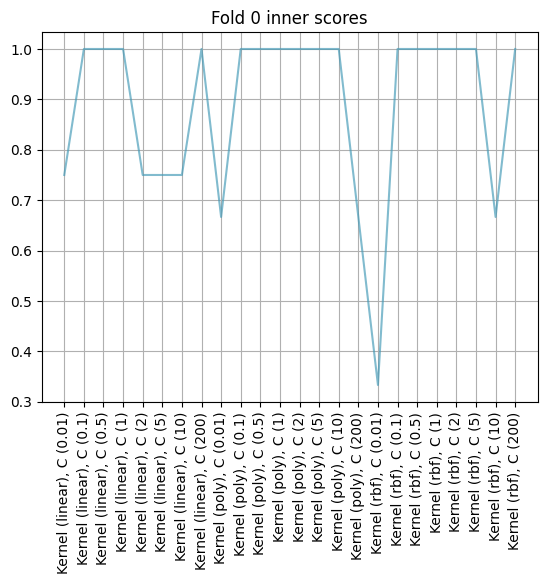

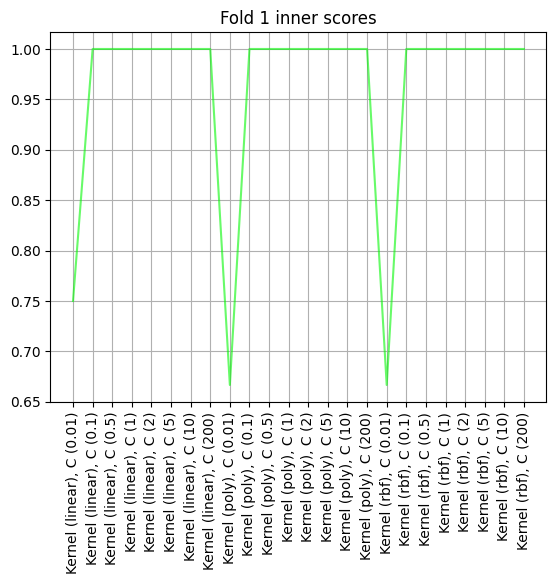

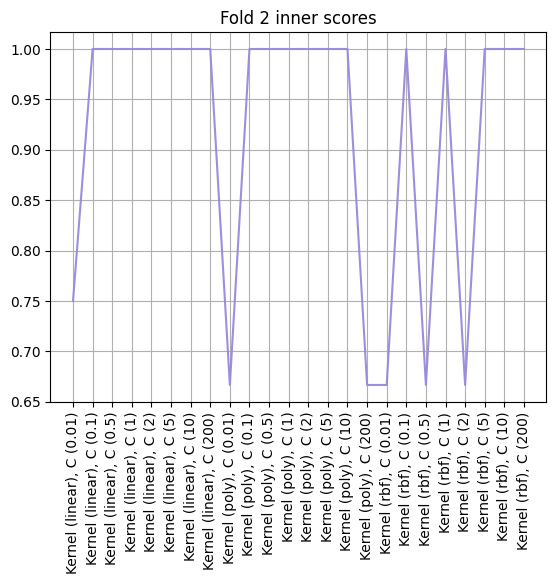

In [95]:
# Nested Stratified KFold

for i, (outer_train_index, outer_test_index) in enumerate(kf_outer.split(X_train, y_train)):
    X_outer_train, y_outer_train = X_train[outer_train_index], y_train[outer_train_index]
    X_outer_test, y_outer_test = X_train[outer_test_index], y_train[outer_test_index]
    # print(y_outer_train)
    # print(y_outer_test)

    fig, ax = plt.subplots()
    inner_scores = []
    inner_best_params = []
    inner_max_score = 0
    for j, (inner_train_index, inner_test_index) in enumerate(kf_inner.split(X_outer_train, y_outer_train)):  
        X_inner_train, y_inner_train = X_outer_train[inner_train_index], y_outer_train[inner_train_index]
        X_inner_test, y_inner_test = X_outer_train[inner_test_index], y_outer_train[inner_test_index]
        
        svc = svm.SVC(C=parameters_grid[j][1], kernel=parameters_grid[j][0])
        svc.fit(X_inner_train, y_inner_train)
        y_pred_inner = svc.predict(X_inner_test)
        # print(f"y_pred: {y_pred_inner}; true: {y_inner_test}")
        # inner_scores.append(f1_score(y_inner_test, y_pred_inner, average='weighted'))
        inner_scores.append(accuracy_score(y_inner_test, y_pred_inner))
        if inner_scores[j] > inner_max_score:
            inner_max_score = inner_scores[j]
            inner_best_params = [parameters_grid[j]]
        elif inner_scores[j] == inner_max_score:
            inner_best_params.append(parameters_grid[j])

    ax.plot([j for j in range(inner_n)], inner_scores,  c=np.random.rand(4,))
    labels = [f"Kernel ({pair[0]}), C ({pair[1]})" for i, pair in enumerate(parameters_grid)]
    # ax.set_xticklabels(labels)
    plt.xticks([j for j in range(inner_n)], labels, rotation='vertical')
    plt.title(f"Fold {i} inner scores")
    plt.grid()
    plt.show()

    outer_best_params = []
    outer_max_score = 0
    for params_candidate in inner_best_params:
        svc_outer = svm.SVC(C=params_candidate[1], kernel=params_candidate[0])
        svc_outer.fit(X_outer_train, y_outer_train)

        y_pred_outer = svc_outer.predict(X_outer_test)
        # print(y_pred_outer)
        score_candidate = f1_score(y_outer_test, y_pred_outer, average='weighted')
        if score_candidate > outer_max_score:
            outer_max_score = score_candidate
            outer_best_params = params_candidate

    outer_scores.append(outer_max_score)
    outer_params.append(outer_best_params)

In [96]:
# Nested CV results
print(outer_scores)
print(outer_params)

max_score = max(outer_scores)
best_params = outer_params[outer_scores.index(max_score)]
print(f"Best params for SVM: {best_params}")

best_svm = svm.SVC(C=best_params[1], kernel=best_params[0])
best_svm.fit(X_train, y_train)

y_pred = best_svm.predict(X_test)

print(f"final score: {f1_score(y_test, y_pred, average='weighted')}")

[1.0, 0.9243793103448276, 1.0]
[('linear', 0.5), ('linear', 0.1), ('linear', 0.5)]
Best params for SVM: ('linear', 0.5)
final score: 1.0
